# Task 1: Faster RCNN

## Overview of the Assignment
In this assignment, we implemented object detection using a pre-trained Faster R-CNN model. The primary objective was to process a video, detect specific objects (`person` and `sports ball`) present in the frames, and visualize the detection results. 

Faster R-CNN is a state-of-the-art object detection framework that combines region proposal generation and object classification into a unified system. It uses a pre-trained backbone network (like ResNet50) for feature extraction and incorporates a Region Proposal Network (RPN) for identifying potential regions of interest. This model was selected for its robustness and compatibility with the COCO dataset, which includes the object classes required for this task.

---

## Tasks Completed in the Assignment

### 1. **Using Pre-trained Faster R-CNN**
- Incorporated `FasterRCNN_ResNet50_FPN` from the `torchvision` library, pre-trained on the COCO dataset. 
- Configured the model for inference, using GPU when available to improve processing speed.
- Limited detection to specific classes (`person` and `sports ball`) by filtering model predictions.

### 2. **Video Frame Processing**
- Extracted frames from the input video using OpenCV.
- Processed each frame through the Faster R-CNN pipeline to identify objects in the frame.
- Added bounding boxes, labels, and confidence scores for each detected object.

### 3. **Visualization and Explanation**
- Rendered the processed frames with bounding boxes around detected objects. Distinct colors were used to differentiate between `person` (blue) and `sports ball` (green).
- The pipeline was explained step-by-step, highlighting key stages like frame extraction, model inference, and result visualization.
- Demonstrated the model's capabilities by displaying sample processed frames with annotations.

---

## Summary of Contributions
This assignment demonstrated how to integrate and utilize a pre-trained Faster R-CNN model for object detection in sports analytics. By focusing on specific classes and visualizing results on video frames, we successfully showcased the pipeline and provided insights into the model's functionality. 


Library Installation**
- The required libraries are installed to ensure the proper environment for running the object detection and video processing tasks:
  - **`yt-dlp`**: For downloading video files from YouTube.
  - **`torch` and `torchvision`**: To use the pre-trained Faster R-CNN model for object detection.
  - **`opencv-python`**: To handle video input, frame processing, and output.
  - **`matplotlib`**: For visualizing processed video frames.
  - **`jupyter`**: For interactive notebook development.
  - **`filterpy`**: For Kalman Filter-based tracking in advanced tasks.

In [1]:
# Install yt-dlp
!pip install --upgrade yt-dlp

# Install PyTorch
!pip install torch torchvision --quiet

# Install OpenCV
!pip install opencv-python --quiet

# Install Matplotlib
!pip install matplotlib --quiet

# Install Jupyter
!pip install jupyter --quiet

# Install the FilterPy library
!pip install filterpy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.9 MB/s eta 0:00:0000:0100:01


## Downloading YouTube Video Using `yt-dlp`

This code snippet uses the `yt-dlp` library to download a YouTube video in the best available quality. It ensures the video is saved in MP4 format with a filename based on the video title. The setup merges video and audio streams if needed, retains intermediate files, and uses FFmpeg for conversion when required. The example URL downloads a football match video for further processing.


In [2]:
import yt_dlp
# Set options for yt-dlp
ydl_opts = {
    'format': 'bestvideo+bestaudio/best',  # Combines best video and audio or falls back to best available
    'outtmpl': '%(title)s.%(ext)s',       # Saves the file using the video's title and correct extension
    'merge_output_format': 'mp4',         # Ensures final output is in MP4 format
    'postprocessors': [
        { 
            'key': 'FFmpegVideoConvertor', 
            'preferedformat': 'mp4'       # Explicitly converts video to MP4 if necessary
        }
    ],
    'keepvideo': True                     # Keeps intermediate video files (if merging is needed)
}

# Download video from YouTube
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/watch?v=l3NJNFmg09k'])


[youtube] Extracting URL: https://www.youtube.com/watch?v=l3NJNFmg09k
[youtube] l3NJNFmg09k: Downloading webpage
[youtube] l3NJNFmg09k: Downloading ios player API JSON
[youtube] l3NJNFmg09k: Downloading mweb player API JSON
[youtube] l3NJNFmg09k: Downloading player 89dfc5b3
[youtube] l3NJNFmg09k: Downloading m3u8 information
[info] l3NJNFmg09k: Downloading 1 format(s): 136+251
[download] Destination: Football match.f136.mp4
[download] 100% of   11.07MiB in 00:00:00 at 25.80MiB/s    
[download] Destination: Football match.f251.webm
[download] 100% of  497.43KiB in 00:00:00 at 11.00MiB/s    
[Merger] Merging formats into "Football match.mp4"
[VideoConvertor] Not converting media file "Football match.mp4"; already is in target format mp4


## Importing Libraries for Object Detection and Tracking

This snippet imports essential libraries required for implementing the Faster-RCNN object detection and Kalman Filter-based tracking:

- **PyTorch and Torchvision**: Used for loading and configuring the pre-trained Faster-RCNN model.
- **OpenCV**: Facilitates video frame processing and manipulation.
- **Matplotlib**: Visualizes detection and tracking results.
- **Numpy**: Handles array operations, often for mathematical computations.
- **tqdm**: Provides progress bars for iterative processes, such as video frame processing.
- **FilterPy**: Implements Kalman Filters for robust object tracking.
- **OS**: Manages file system operations like file paths.

These libraries form the backbone of the sports tracking application by combining detection, visualization, and tracking in a cohesive pipeline.


In [3]:
# PyTorch and torchvision imports for Faster-RCNN
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T

# OpenCV for video processing
import cv2

# Matplotlib for visualizations
import matplotlib.pyplot as plt

# Numpy for array manipulations
import numpy as np

# tqdm for progress bars
from tqdm import tqdm

# Kalman filter from FilterPy for tracking
from filterpy.kalman import KalmanFilter

# OS module for file and directory operations
import os


## GPU Selection for Accelerated Processing

This code checks for the availability of a CUDA-enabled GPU. If a GPU is available, it automatically selects the first GPU (`CUDA_VISIBLE_DEVICES = "0"`) and prints its name, ensuring efficient hardware utilization for faster computations. If no GPU is available, the program gracefully falls back to CPU processing.


In [4]:
import os
import torch

# Automatically select the first available GPU
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use the first GPU
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Falling back to CPU.")


CUDA is available. Using GPU: Tesla T4


## Object Detection and Tracking with Faster R-CNN and Kalman Filters

This code integrates a pretrained Faster R-CNN model with Kalman Filters to detect and track objects (persons and sports balls) in video frames. 

### Key Features:
1. **Object Detection with Faster R-CNN**:
   - Uses a pretrained Faster R-CNN model with ResNet50 as the backbone to detect objects in frames.
   - Filters the detected objects based on confidence scores and desired classes (person and sports ball).

2. **Object Tracking with Kalman Filters**:
   - Each detected object is assigned a unique ID, tracked across frames using Kalman filters.
   - Updates object position based on predictions and measurements to ensure smooth tracking.

3. **Visualization**:
   - Displays bounding boxes, tracking points, and unique IDs for each detected object.
   - Assigns blue for persons and orange for balls, while using yellow for ID labels.

### Highlights:
- Handles multiple objects by associating detections to existing tracks or initializing new ones when necessary.
- Includes a confidence threshold to filter out low-quality detections.
- Visualizes the results clearly to demonstrate the detection and tracking process.

This implementation is useful for analyzing sports footage, tracking players and balls dynamically across video frames.


In [5]:
import cv2
import numpy as np
from filterpy.kalman import KalmanFilter

class SportsTracker:
    def __init__(self):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.setup_model()
        self.transform = T.Compose([T.ToTensor()])
        self.desired_classes = {'person': 1, 'sports ball': 37}
        self.confidence_threshold = 0.5
        self.kalman_filters = {}  # Store Kalman filters for each object
        self.next_object_id = 0  # Counter for assigning unique object IDs

    def setup_model(self):
        """Initialize and configure Faster R-CNN model"""
        model = fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
        model.to(self.device)
        model.eval()
        return model

    def initialize_kalman_filter(self):
        """Initialize Kalman Filter for tracking"""
        kf = KalmanFilter(dim_x=4, dim_z=2)  # State: [x, y, dx, dy], Measurement: [x, y]
        
        # state transition matrix
        kf.F = np.array([[1, 0, 1, 0],
                         [0, 1, 0, 1],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])
        
        # measurement matrix
        kf.H = np.array([[1, 0, 0, 0],
                         [0, 1, 0, 0]])
        
        # measurement noise
        kf.R *= 10
        
        # process noise
        kf.Q *= 0.1
        
        return kf

    def process_frame(self, frame):
        """Process a single frame through Faster R-CNN stages"""
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # BGR to RGB
        frame_tensor = self.transform(frame_rgb).to(self.device)
        
        with torch.no_grad():
            predictions = self.model([frame_tensor])
        
        boxes = predictions[0]['boxes']
        labels = predictions[0]['labels']
        scores = predictions[0]['scores']
        
        filtered_detections = self.filter_detections(boxes, labels, scores)
        tracked_objects = self.update_tracking(filtered_detections)
        
        return self.visualize_detections(frame_rgb, tracked_objects)

    def filter_detections(self, boxes, labels, scores):
        """Filter detections based on the desired classes and confidence threshold"""
        filtered = []
        for box, label, score in zip(boxes, labels, scores):
            if label.item() in self.desired_classes.values() and score > self.confidence_threshold:
                filtered.append({
                    'box': box.cpu().numpy(),
                    'label': label.item(),
                    'score': score.item()
                })
        return filtered

    def update_tracking(self, detections):
        """Update Kalman filter tracking for detected objects and assign unique IDs"""
        tracked = []
        for det in detections:
            box = det['box']
            center_x = (box[0] + box[2]) / 2
            center_y = (box[1] + box[3]) / 2
            
            obj_id = None
            # Check if this object already has a Kalman filter
            for existing_id, kf in self.kalman_filters.items():
                # Compare center positions to see if this is a new or existing object
                if np.linalg.norm(kf.x[:2] - np.array([[center_x], [center_y]])) < 50:  # Threshold for matching
                    obj_id = existing_id
                    break
            
            # If no existing ID is found, assign a new ID
            if obj_id is None:
                obj_id = self.next_object_id
                self.next_object_id += 1  # Increment for next unique ID
                self.kalman_filters[obj_id] = self.initialize_kalman_filter()
                self.kalman_filters[obj_id].x = np.array([[center_x], [center_y], [0], [0]])

            # Update Kalman filter
            kf = self.kalman_filters[obj_id]
            kf.predict()
            kf.update(np.array([[center_x], [center_y]]))
            
            tracked.append({
                'box': box,
                'label': det['label'],
                'score': det['score'],
                'position': kf.x[:2].flatten(),
                'id': obj_id  # Add the ID of the object
            })
        
        return tracked

    def visualize_detections(self, frame, tracked_objects):
        """Visualize detected objects, their tracks, and IDs"""
        frame_copy = frame.copy()

        for obj in tracked_objects:
            box = obj['box']
            label = obj['label']
            score = obj['score']
            position = obj['position']
            obj_id = obj['id']  # Get the ID of the object
            
            # Assign color based on object label (Person: Blue, Ball: Orange)
            if label == 1:  # Person
                color = (255, 0, 0)  # Blue for person
            else:  # Ball
                color = (0, 165, 255)  # Orange for ball

            # Draw bounding box
            cv2.rectangle(frame_copy, 
                          (int(box[0]), int(box[1])), 
                          (int(box[2]), int(box[3])), 
                          color, 2)

            # Draw tracking position as a circle
            cv2.circle(frame_copy, 
                       (int(position[0]), int(position[1])), 
                       4, color, -1)

            # Add label text with ID and confidence score
            label_text = f"ID: {obj_id} {'Person' if label == 1 else 'Ball'}: {score:.2f}"
            # Use yellow color for ID text
            cv2.putText(frame_copy, label_text, 
                        (int(box[0]), int(box[1] - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

        return frame_copy


## Video Processing with Object Detection and Tracking

This code processes an entire video file, applying object detection and tracking using Faster R-CNN and Kalman Filters to detect and track objects (like persons and sports balls). It reads the video, processes each frame, and outputs a new video with annotated bounding boxes and tracked objects.

### Key Steps:
1. **Video Initialization**:
   - The video is opened using OpenCV’s `cv2.VideoCapture()`.
   - The video properties such as frame width, height, FPS, and total frames are retrieved to set up the video writer.

2. **Object Detection and Tracking**:
   - A `SportsTracker` object is initialized, which uses Faster R-CNN for object detection and Kalman Filters for object tracking across frames.
   - Each frame is processed to detect and track persons and sports balls, adding tracking IDs and drawing bounding boxes.

3. **Progress Bar**:
   - A progress bar (using `tqdm`) is initialized to visualize the processing of frames, making it easier to track the progress of the video processing.

4. **Saving Processed Video**:
   - The processed frames are written to a new output video file using OpenCV’s `cv2.VideoWriter()`.

5. **Resource Management**:
   - The video capture and writer objects are released after the video processing is completed.
   
### Output:
- The output video is saved with the processed frames, where objects are detected, tracked, and labeled with their unique IDs.
- If the output directory does not exist, it is created dynamically.

This process helps in real-time video analysis, such as tracking players and sports balls in sports videos or any other application that requires object detection and tracking across video frames.


In [6]:
import cv2
from tqdm import tqdm
import os

def process_video(video_path, output_path):
    """Process entire video file"""
    tracker = SportsTracker()
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        raise ValueError("Error: Could not open video.")
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Check if the output directory exists; if not, create it
    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Set up video writer to save processed video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' is a codec for .mp4 files
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    # Initialize a progress bar
    pbar = tqdm(total=total_frames, desc="Processing Frames")
    
    # Read and process each frame
    while True:
        success, frame = cap.read()
        if not success:
            break  # Break if the frame is not read successfully (end of video)
        
        # Process the current frame
        processed_frame = tracker.process_frame(frame)
        
        # Write the processed frame to the output video
        out.write(cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR))
        
        # Update the progress bar
        pbar.update(1)
    
    # Release resources and close the progress bar
    pbar.close()
    cap.release()  # Release the video capture object
    out.release()  # Release the video writer object
    
    print("Video processing completed.")


## Running the Video Processing

In this section, the video processing pipeline is initialized and executed using the specified video file. The script checks the existence of the input video and manages the output directory before processing the video.

### Key Steps:
1. **Input Video Validation**:
   - The input video file path is specified (`Football match.f136.mp4`).
   - The script checks if the file exists using `os.path.exists()`. If the file is not found, a `FileNotFoundError` is raised, ensuring that the program does not proceed without a valid video input.

2. **Output Directory Management**:
   - The output video file path is defined (`output task1.mp4`).
   - The script ensures that the directory for the output file exists. If not, it creates the necessary directories using `os.makedirs()`.

3. **Processing the Video**:
   - The `process_video()` function is called, which performs object detection and tracking on the input video and saves the processed video to the output path.
   - If any error occurs during video processing, it is caught and printed.

### Output:
- After successful execution, the processed video is saved to the specified output path (`output task1.mp4`).
- Any errors encountered during processing are captured and displayed for debugging.

This structure ensures a robust workflow that handles file paths, directory management, and error handling gracefully, making it easier to run the object detection and tracking process without issues.


In [7]:
import os

if __name__ == "__main__":
    # Define video paths
    video_path = 'Football match.f136.mp4'
    output_path = 'output task1.mp4'

    # Check if the input video exists
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Error: The input video '{video_path}' does not exist.")
    
    # Check if the output directory exists; if not, create it
    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Process the video
    try:
        process_video(video_path, output_path)
        print(f"Video processing completed. Output saved to {output_path}")
    except Exception as e:
        print(f"Error occurred during video processing: {e}")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 182MB/s]  
Processing Frames: 100%|██████████| 1074/1074 [03:11<00:00,  5.62it/s]

Video processing completed.
Video processing completed. Output saved to output task1.mp4


## Displaying a Specific Frame from the Video

In this section, the script is designed to open a video file and process a specific frame from it using the Faster-RCNN model with the help of a custom tracking class (`SportsTracker`).

### Key Steps:

1. **Video File Opening**:
   - The video file `Football match.f136.mp4` is opened using OpenCV’s `cv2.VideoCapture()`. If the video cannot be opened (e.g., due to an incorrect path or corrupted file), an error message is printed.

2. **Set Frame Index**:
   - The script sets the frame index to `300`, which is the 300th frame of the video, using `cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)`. This allows the user to target and process a specific frame.

3. **Reading the Frame**:
   - The frame at index `300` is read from the video. If the frame is successfully read (`success` is `True`), the script proceeds to process it.

4. **Frame Processing**:
   - The `SportsTracker` class is instantiated to perform object detection and tracking. The `process_frame()` method of the `SportsTracker` class is applied to the selected frame.
   
5. **Displaying the Processed Frame**:
   - The processed frame is displayed using Matplotlib. Since OpenCV uses BGR format by default, this frame is shown as-is without any color format conversion. The axes are hidden using `plt.axis('off')` for a cleaner view.

6. **Error Handling**:
   - If the frame could not be read, an error message is printed.

7. **Release Resources**:
   - Finally, the `cap.release()` method is called to release the video capture object, freeing up system resources.

### Output:
- If the frame is successfully processed, a visual of the frame with detected objects and tracking is displayed.
- If the frame could not be read or processed, an appropriate error message is shown.

This approach allows you to visualize specific frames from the video, with object detection and tracking applied, helping with debugging or analysis of particular frames in the video.


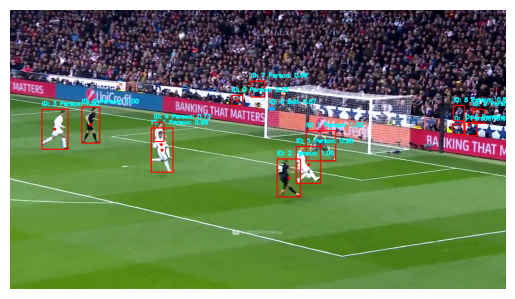

In [8]:
import cv2
import matplotlib.pyplot as plt

# Open the video file
cap = cv2.VideoCapture('Football match.f136.mp4')

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # Set the frame index
    frame_index = 300
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read the specific frame
    success, frame = cap.read()

    if success:
        # Initialize the tracker
        tracker = SportsTracker()

        # Process the frame using the tracker
        processed_frame = tracker.process_frame(frame)

        # Display the processed frame using Matplotlib (BGR format remains unchanged)
        plt.imshow(processed_frame)
        plt.axis('off')  # Hide the axes
        plt.show()

    else:
        print("Error: Failed to read the frame from video.")

# Release the video capture object
cap.release()



## Output for Video

Here is the output for the video with object detection and tracking applied:

[Watch the video here](https://drive.google.com/file/d/1OUjnab4j3rXGmoTty3cU3dv433rLn_RF/view?usp=sharing)

In the video, you can observe the detection of objects, such as persons and sports balls, and their tracking using unique IDs. The tracking is implemented using a Kalman filter, ensuring smooth tracking even with occlusions or movements.
